#Libs

In [1]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # <-- for plotting
from tqdm import tqdm
from collections import deque
import scipy.stats as stats # <-- for bimodality


from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action



# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action
Using device: cuda


In [2]:
# ----------------------
# 1) Modified Environment with 9 Discrete Actions
# ----------------------
class OpinionEnv9Actions:
    """
    A vectorized environment with exactly 9 discrete actions for each "player" (row & column).
    Each action maps to M/2 Bernoulli bits using 'probabilities' and 'deltas', then we concatenate
    row & column to form an M-dimensional 'action' for the media update.

    The adjacency factor for media is:
        fac = (1 + eta * action) * (1 + eta2 * (2 - c - action)*(1 - s))

    Credibility is updated with: c = gamma * c + (1 - gamma)*action
    The observation is a histogram of x plus the current credibility c.
    """

    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=5,
                 b=20,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        """
        :param num_envs:       Number of parallel envs
        :param N:              Number of agents
        :param M:              Media dimension
        :param terminal_time:  Steps until done
        :param bM, b:          Coupling constants for media and social
        :param noise_level:    Std dev of noise
        :param h:              Euler step size
        :param nbins:          Number of histogram bins
        :param r_scale:        Scale factor for rewards
        :param eta, eta2:      Multipliers in the adjacency factor
        :param beta_1, beta_2: Beta distribution parameters for susceptibility
        :param gamma:          Credibility discount factor
        """
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        self.BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Shared across all envs: media positions in [-1,1], shape [M]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        # x: shape [num_envs, N]
        # c: shape [num_envs, M]
        # t: shape [num_envs]
        # s: shape [num_envs, N] (from BetaDist)
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm=torch.zeros((self.num_envs,self.N,self.M),device=device)
        # Exactly 9 actions
        self.action_dim = 9

        # Prob & delta for each of the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        # Init
        self.reset()

    def reset(self):
        """
        Reset all envs to initial state.
        """
        with torch.no_grad():
            # x in [-1,1]
            self.x.uniform_(-1.0, 1.0)
            # c=1
            self.c.fill_(1.0)
            # t=0
            self.t.zero_()
            # Misinfo Exposure
            self.AEm.fill_(0.0)
            # If you want to re-sample s here, uncomment:
            self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)

        return self.state2obs()

    def state2obs(self):
        """
        Observation shape [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            # histogram of x[i] with nbins in [-1,1], normalized
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            # c[i]: shape [M]
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        # stack => shape [num_envs, nbins+M]
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        final_prob = base_prob - zm * delta_prob
        Then sample Bernoulli( final_prob ).
        Returns shape [num_envs, M//2].
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]

        # final_prob[i,j] = base_probs[i] - (zm[j]*delta_probs[i])
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0)*delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # [num_envs, M//2]

    def simulate(self, action_pl_ids, action_op_ids):
        """
        simulate the environment by 1 Euler iteration using row/column action IDs in {0..8}.
        Returns next_obs, rewards, done, info.
        """
        with torch.no_grad():
          for _ in range(self.terminal_time):
            # Build row & column actions => [num_envs, M//2]
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            # Combine => [num_envs, M]
            action = torch.cat([row_act, col_act], dim=1)

            # Distances
            DM = self.ym.view(1,1,-1) - self.x.unsqueeze(2)  # [num_envs,N,M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1,2)                      # [num_envs,N,N]

            # Media adjacency factor:
            # fac = (1 + eta*action) * (1 + eta2*(2-c-action)*(1-s))
            # We'll do shape expansions:
            #   action => [num_envs,M] => unsqueeze(1)->[num_envs,1,M]
              # (2-c-action) => same shape => unsqueeze(1)->[num_envs,1,M]
            #   (1-s) => [num_envs,N] => unsqueeze(2)->[num_envs,N,1]
            fac = (1.0 + self.eta*action).unsqueeze(1) * (
                1.0 + self.eta2*(2.0 - self.c - action).unsqueeze(1)*(1.0 - self.s).unsqueeze(2)
            )

            AM = torch.exp(-self.bM * fac * torch.abs(DM))  # [num_envs,N,M]
            A = torch.exp(-self.b * torch.abs(D))           # [num_envs,N,N]
            self.media_attention=AM

            self.AEm += torch.exp(-self.bM * torch.abs(DM))* (1-action.unsqueeze(1))
            # Credibility update => c = gamma*c + (1-gamma)*action
            self.c = self.c*self.lambda_c + action*(1-self.lambda_c)

            # Weighted updates for x D has sign in it
            x_update_social = -(A * D).sum(dim=2)/A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2)/AM.sum(dim=2).clamp_min(1e-12)

            # Noise
            noise = torch.normal(
                mean=0.0, std=self.noise_level,
                size=(self.num_envs, self.N),
                device=device
            )

            # Euler update
            self.x = self.x + self.h*(x_update_social + x_update_media) + torch.sqrt(self.h)*noise

            # time
            self.t += 1

            # Reward => r_scale * -avg( sin^5(pi*x/2) )
            sin_val = torch.sin((self.pi/2.0)*self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)  # [num_envs]
            rewards = self.r_scale * (-mean_sin_pow5)

            # Done?
            done = (self.t >= self.terminal_time)
        return rewards

In [3]:
# Make sure that a device is defined for both the environment and the simulation.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bimodality_coefficient(data):
    """
    Compute the bimodality coefficient from the skewness and (non-Fisher) kurtosis.
    """
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data, fisher=False)
    bc = (skewness**2 + 1) / kurtosis
    return bc

def run_simulation(i, j, env):
    """
    Reset the environment, create parallel vectors of action IDs (one per env) using the
    provided scalar choices (i and j), run the simulation (which steps for terminal_time iterations)
    and return the average reward.
    """
    env.reset()
    action_ids_player = i * torch.ones(env.num_envs, device=device, dtype=torch.int64)
    action_ids_opponent = j * torch.ones(env.num_envs, device=device, dtype=torch.int64)

    # Run the simulation; the new simulate() method runs a full trajectory and returns rewards.
    rewards = env.simulate(action_ids_player, action_ids_opponent)
    return rewards.mean().item()

def QRE(A, taw=0.1, device=device):
    """
    Compute a Quantal Response Equilibrium (QRE) solution for a given payoff matrix A.
    (This is essentially unchanged except for minor clarifications and explicit normalization.)
    """
    Ar = A / A.abs().max()
    mu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)
    nu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)

    eta = taw / 30
    for _ in range(3 * 10**4):
        mu_old = mu.clone()
        nu_old = nu.clone()

        mub = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nu))
        mub = mub / mub.sum()
        nub = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mu))
        nub = nub / nub.sum()

        mu = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nub))
        mu = mu / mu.sum()
        nu = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mub))
        nu = nu / nu.sum()

        # Compute the duality gap; stop if it is sufficiently small.
        DG = (nu_old.t() @ Ar @ mu) - (nu.t() @ Ar @ mu_old)
        if DG.abs().item() < 1e-7:
            break
    return mu, nu

def Generator(env,eta1, eta2, Taw=0.1):
    """
    Load the payoff matrix A, compute a QRE (which gives a probability distribution over actions),
    instantiate the updated environment OpinionEnv9Actions, sample one action (per “player”) from the QRE,
    run a simulation, and return the final opinions x, susceptibilities s, and credibility c.
    (The fourth returned value is set to None because the previous code returned env.AEm which is no longer defined.)
    """
    # Load the payoff matrix from file.
    load_file=f'Payoff_matrix/Payoff-eta1_{round(eta1, 1)}eta2_{round(eta2, 1)}.pt'
    A = torch.load(load_file)
    M = 10
    N = 500
    terminal_time = 200

    # (Optional) Set the plot font style.
    plt.rc('font', family='serif', size=18)

    # Compute the QRE equilibrium strategies.
    mu, nu = QRE(A, taw=Taw, device=device)

    # Instantiate the updated environment.
    # Note: Here we choose num_envs=200 (as a replacement for the old 'num_batches').

    # Sample one action index for each of the two “players” from the QRE distributions.
    # We use num_samples=1 so that a single action is applied to all parallel environments.
    action_i = torch.multinomial((mu / mu.sum()).view(-1), num_samples=1, replacement=True).item()
    action_j = torch.multinomial((nu / nu.sum()).view(-1), num_samples=1, replacement=True).item()
    # Run the simulation using the selected actions.
    run_simulation(action_i, action_j, env)
    # Extract the final state components.
    # In the new environment, opinions are stored in env.x, credibility in env.c, and susceptibility in env.s.
    x = env.x.cpu().numpy().flatten()
    s = env.s.cpu().numpy().flatten()
    c = env.c.cpu().numpy().flatten()

    # The original code returned a fourth variable (env.AEm); here we return None.
    return x, s, c, None

#xi-eta

In [ ]:
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/cluster
data2 = torch.load('results/data-final-part2.pt')
data1 = torch.load('results/data-final.pt')

/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/cluster


<ipython-input-4-e5a7d1a0fc35>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data2 = torch.load('results/data-final-part2.pt')
<ipython-input-4-e5a7d1a0fc35>:3: FutureWar

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/cluster

Eta1_list = np.arange(0, 2.1, 0.2)
Eta2_list = np.arange(0, 6.1, 0.2)
Bibmodal=np.zeros((31,len(Eta2_list)))
exposure=np.zeros((31,len(Eta2_list)))
for eta1_idx, eta1 in enumerate(Eta1_list):
    for eta2_idx, eta2 in enumerate(Eta2_list):
      Bibmodal[eta1_idx,eta2_idx]=data1[eta1_idx][eta2_idx]['bimodality']
      exposure[eta1_idx,eta2_idx]=data1[eta1_idx][eta2_idx]['c'].mean()

Eta1_list = np.arange(2.1, 6.1, 0.2)
for eta1_idx, eta1 in enumerate(Eta1_list):
    for eta2_idx, eta2 in enumerate(Eta2_list):
      # print(f"{eta1_idx},{eta2_idx}")
      Bibmodal[11+eta1_idx,eta2_idx]=data2[eta1_idx][eta2_idx]['bimodality']
      exposure[11+eta1_idx,eta2_idx]=data2[eta1_idx][eta2_idx]['c'].mean()

/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/cluster


/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action


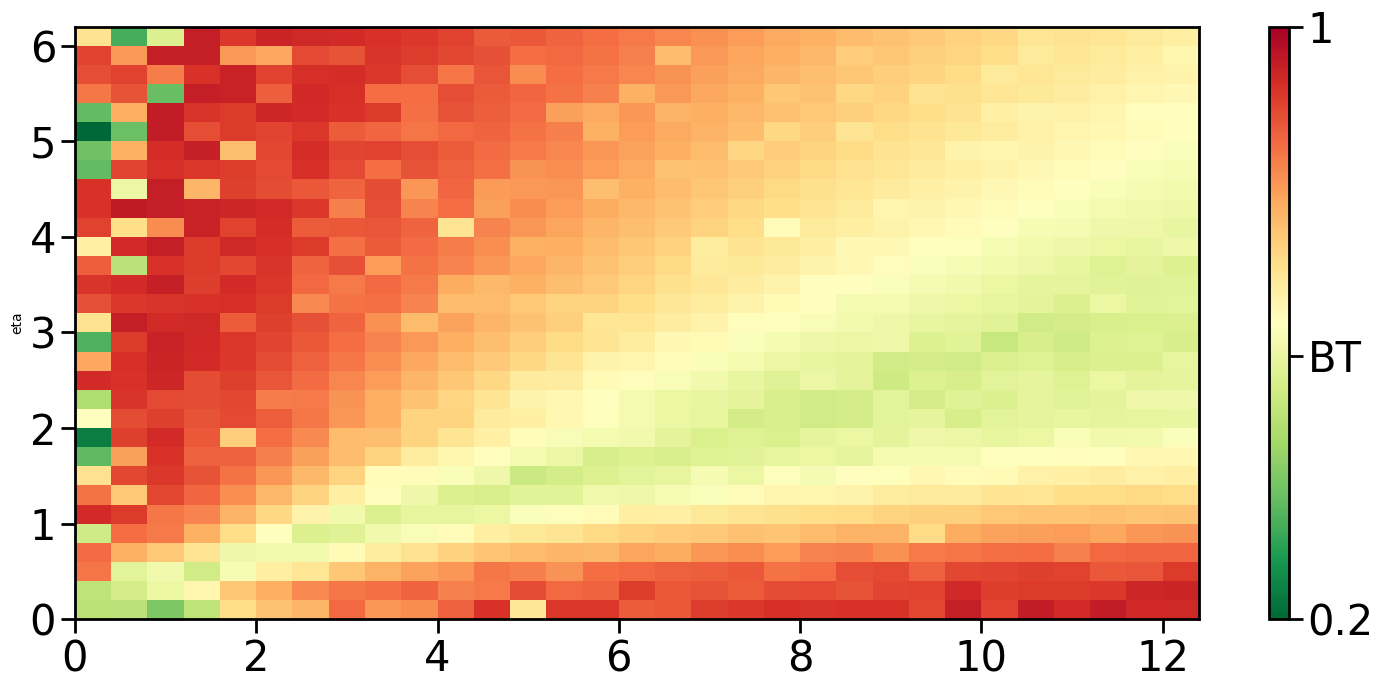

In [ ]:


%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action
v=[0.2,.6,1]
divnorm=colors.TwoSlopeNorm(vmin=v[0], vcenter=v[1], vmax=v[2])
fig, ax = plt.subplots(1,1,figsize=(15, 7))
cax=ax.pcolormesh(Bibmodal, cmap="RdYlGn_r", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax,ticks=[v[0] ,5/9,v[2]],aspect=30)
cbar.ax.set_yticklabels([str(v[0]), 'BT', str(v[2])])
cbar.ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
ax.set_xticks([0,5,10,15,20,25,30],[0,2,4,6,8,10,12])
ax.set_yticks([0,5,10,15,20,25,30],[0,1,2,3,4,5,6])


ax.set_ylabel('eta')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)
plt.tight_layout()
plt.savefig("plots/xi-eta-bimodal.svg",dpi=300)
plt.show()

/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action


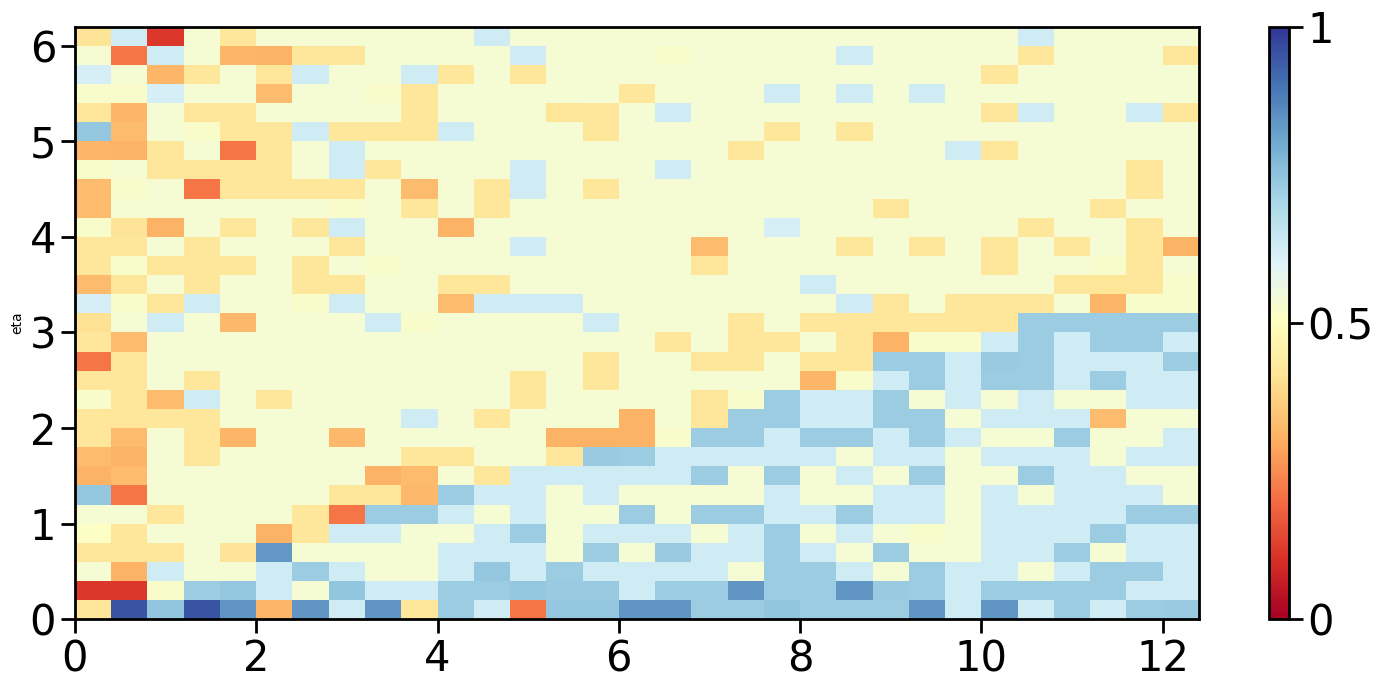

In [ ]:


%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action
v=[0,.5,1]
divnorm=colors.TwoSlopeNorm(vmin=v[0], vcenter=v[1], vmax=v[2])
fig, ax = plt.subplots(1,1,figsize=(15, 7))
cax=ax.pcolormesh(exposure, cmap="RdYlBu", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax,ticks=[v[0] ,v[1],v[2]],aspect=30)
cbar.ax.set_yticklabels([str(v[0]), v[1] ,str(v[2])])
cbar.ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)

ax.set_xticks([0,5,10,15,20,25,30],[0,2,4,6,8,10,12])
ax.set_yticks([0,5,10,15,20,25,30],[0,1,2,3,4,5,6])
# ax.set_yticks([0,5,10],[0,1,2])

ax.set_ylabel('eta')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)
plt.tight_layout()
plt.savefig("plots/xi-eta-crediblity.svg",dpi=300)
plt.show()




In [ ]:
data2[10][10]['c'].reshape(-1,10).mean(axis=0)

array([0.11445343, 0.32447815, 0.533169  , 0.7414668 , 0.95269245,
       0.9505596 , 0.7421422 , 0.5358972 , 0.3227472 , 0.1160056 ],
      dtype=float32)

/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action


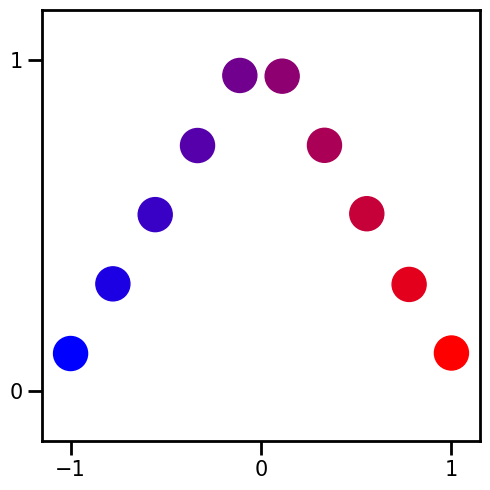

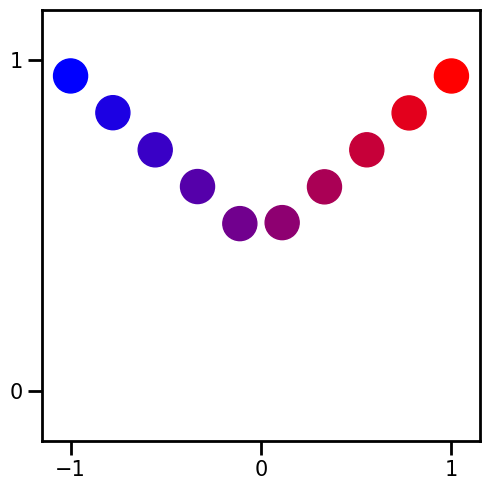

In [ ]:
#########################################
#  3) Plotting Equilibrium Distributions
#########################################
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/
from matplotlib.colors import LinearSegmentedColormap
# Plot final average credibility
c=data2[10][10]['c'].reshape(-1,10).mean(axis=0)
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
fig, ax = plt.subplots(figsize=(5, 5))
ym=np.linspace(-1,1,10)
ax.scatter(ym, c, s=600, c=ym, cmap=cmap, alpha=1)
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('plots/phase1.svg')
plt.show()



#########################################
#  3) Plotting Equilibrium Distributions
#########################################

# Plot final average credibility
c=data1[5][21]['c'].reshape(-1,10).mean(axis=0)
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(ym, c, s=600, c=ym, cmap=cmap, alpha=1)
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('plots/phase2.svg')
plt.show()


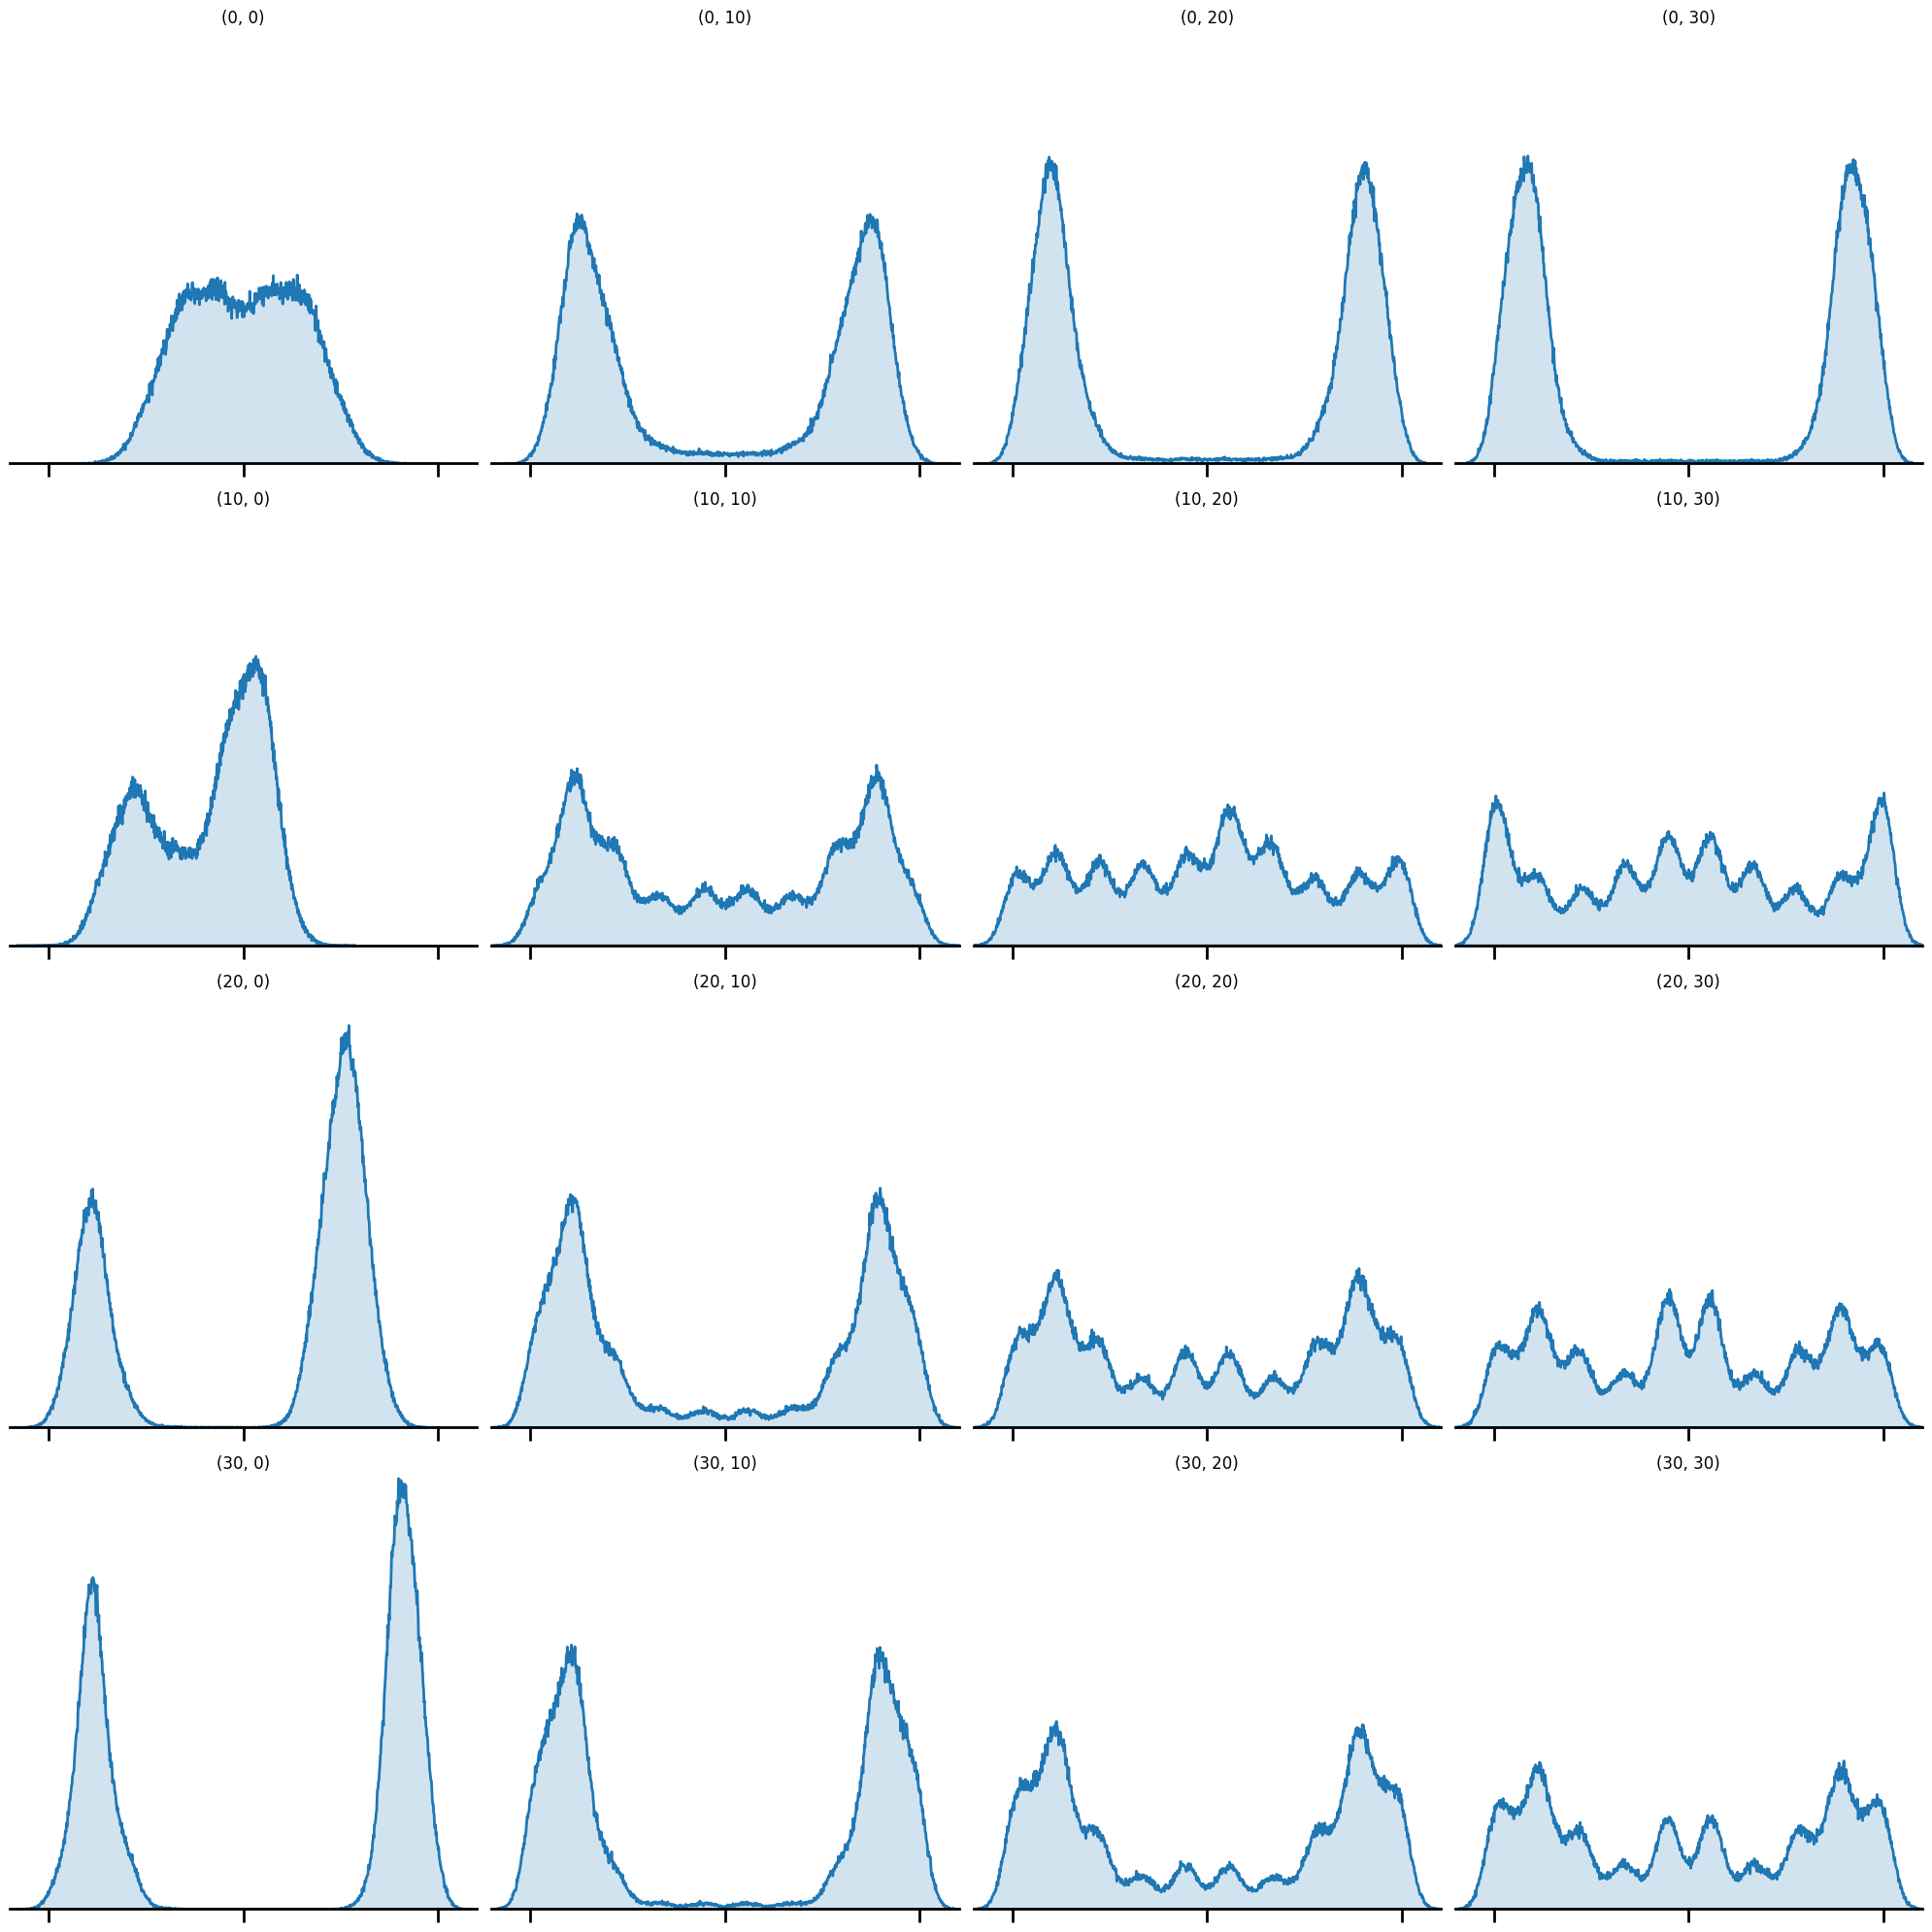

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 4x4 grid, larger figure size

# Flatten the axes array for easier indexing
axes = axes.flatten()

plot_idx = 0  # To track subplot index

for i in [0, 10, 20, 30]:
    for j in [0, 10, 20, 30]:
        ax = axes[plot_idx]  # Select the correct subplot

        if i < 11:
            x = data1[i][j]['x']
        else:
            x = data2[i - 10][j]['x']

        sns.histplot(x, bins=1000, element="poly", stat="density", alpha=0.2, linewidth=2, ax=ax)

        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(0, 2.7)
        ax.set_xticks([-1, 0, 1])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
        ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel('')
        ax.set_title(f"{i,j}")

        plot_idx += 1  # Move to the next subplot

plt.tight_layout()
plt.savefig("plots/Grid_Distributions.svg", dpi=300)  # Save as a single file
plt.show()


# Susceptiblity

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # <-- for plotting
from tqdm import tqdm
from collections import deque
import scipy.stats as stats # <-- for bimodality

# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ----------------------
# 1) Modified Environment with 9 Discrete Actions
# ----------------------
class OpinionEnv9Actions:
    """
    A vectorized environment with exactly 9 discrete actions for each "player" (row & column).
    Each action maps to M/2 Bernoulli bits using 'probabilities' and 'deltas', then we concatenate
    row & column to form an M-dimensional 'action' for the media update.

    The adjacency factor for media is:
        fac = (1 + eta * action) * (1 + eta2 * (2 - c - action)*(1 - s))

    Credibility is updated with: c = gamma * c + (1 - gamma)*action
    The observation is a histogram of x plus the current credibility c.
    """

    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=5,
                 b=20,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        """
        :param num_envs:       Number of parallel envs
        :param N:              Number of agents
        :param M:              Media dimension
        :param terminal_time:  Steps until done
        :param bM, b:          Coupling constants for media and social
        :param noise_level:    Std dev of noise
        :param h:              Euler step size
        :param nbins:          Number of histogram bins
        :param r_scale:        Scale factor for rewards
        :param eta, eta2:      Multipliers in the adjacency factor
        :param beta_1, beta_2: Beta distribution parameters for susceptibility
        :param gamma:          Credibility discount factor
        """
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        self.BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Shared across all envs: media positions in [-1,1], shape [M]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        # x: shape [num_envs, N]
        # c: shape [num_envs, M]
        # t: shape [num_envs]
        # s: shape [num_envs, N] (from BetaDist)
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm=torch.zeros((self.num_envs,self.N,self.M),device=device)
        # Exactly 9 actions
        self.action_dim = 9

        # Prob & delta for each of the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        # Init
        self.reset()

    def reset(self):
        """
        Reset all envs to initial state.
        """
        with torch.no_grad():
            # x in [-1,1]
            self.x.uniform_(-1.0, 1.0)
            # c=1
            self.c.fill_(1.0)
            # t=0
            self.t.zero_()
            # Misinfo Exposure
            self.AEm.fill_(0.0)
            # If you want to re-sample s here, uncomment:
            self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)

        return self.state2obs()

    def state2obs(self):
        """
        Observation shape [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            # histogram of x[i] with nbins in [-1,1], normalized
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            # c[i]: shape [M]
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        # stack => shape [num_envs, nbins+M]
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        final_prob = base_prob - zm * delta_prob
        Then sample Bernoulli( final_prob ).
        Returns shape [num_envs, M//2].
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]

        # final_prob[i,j] = base_probs[i] - (zm[j]*delta_probs[i])
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0)*delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # [num_envs, M//2]

    def simulate(self, action_pl_ids, action_op_ids):
        """
        simulate the environment by 1 Euler iteration using row/column action IDs in {0..8}.
        Returns next_obs, rewards, done, info.
        """
        with torch.no_grad():
          for _ in range(self.terminal_time):
            # Build row & column actions => [num_envs, M//2]
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            # Combine => [num_envs, M]
            action = torch.cat([row_act, col_act], dim=1)

            # Distances
            DM = self.ym.view(1,1,-1) - self.x.unsqueeze(2)  # [num_envs,N,M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1,2)                      # [num_envs,N,N]

            # Media adjacency factor:
            # fac = (1 + eta*action) * (1 + eta2*(2-c-action)*(1-s))
            # We'll do shape expansions:
            #   action => [num_envs,M] => unsqueeze(1)->[num_envs,1,M]
              # (2-c-action) => same shape => unsqueeze(1)->[num_envs,1,M]
            #   (1-s) => [num_envs,N] => unsqueeze(2)->[num_envs,N,1]
            fac = (1.0 + self.eta*action).unsqueeze(1) * (
                1.0 + self.eta2*(2.0 - self.c - action).unsqueeze(1)*(1.0 - self.s).unsqueeze(2)
            )

            AM = torch.exp(-self.bM * fac * torch.abs(DM))  # [num_envs,N,M]
            A = torch.exp(-self.b * torch.abs(D))           # [num_envs,N,N]
            self.media_attention=AM

            self.AEm += torch.exp(-self.bM * torch.abs(DM))* (1-action.unsqueeze(1))
            # Credibility update => c = gamma*c + (1-gamma)*action
            self.c = self.c*self.lambda_c + action*(1-self.lambda_c)

            # Weighted updates for x D has sign in it
            x_update_social = -(A * D).sum(dim=2)/A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2)/AM.sum(dim=2).clamp_min(1e-12)

            # Noise
            noise = torch.normal(
                mean=0.0, std=self.noise_level,
                size=(self.num_envs, self.N),
                device=device
            )

            # Euler update
            self.x = self.x + self.h*(x_update_social + x_update_media) + torch.sqrt(self.h)*noise

            # time
            self.t += 1

            # Reward => r_scale * -avg( sin^5(pi*x/2) )
            sin_val = torch.sin((self.pi/2.0)*self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)  # [num_envs]
            rewards = self.r_scale * (-mean_sin_pow5)

            # Done?
            done = (self.t >= self.terminal_time)
        return rewards



def run_simulation(i, j, env):
    """
    Reset the environment, create parallel vectors of action IDs (one per env) using the
    provided scalar choices (i and j), run the simulation (which steps for terminal_time iterations)
    and return the average reward.
    """
    env.reset()
    action_ids_player = i * torch.ones(env.num_envs, device=device, dtype=torch.int64)
    action_ids_opponent = j * torch.ones(env.num_envs, device=device, dtype=torch.int64)

    # Run the simulation; the new simulate() method runs a full trajectory and returns rewards.
    rewards = env.simulate(action_ids_player, action_ids_opponent)
    return rewards.mean().item()

def QRE(A, taw=0.1, device=device):
    """
    Compute a Quantal Response Equilibrium (QRE) solution for a given payoff matrix A.
    (This is essentially unchanged except for minor clarifications and explicit normalization.)
    """
    Ar = A / A.abs().max()
    mu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)
    nu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)

    eta = taw / 30
    for _ in range(3 * 10**4):
        mu_old = mu.clone()
        nu_old = nu.clone()

        mub = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nu))
        mub = mub / mub.sum()
        nub = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mu))
        nub = nub / nub.sum()

        mu = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nub))
        mu = mu / mu.sum()
        nu = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mub))
        nu = nu / nu.sum()

        # Compute the duality gap; stop if it is sufficiently small.
        DG = (nu_old.t() @ Ar @ mu) - (nu.t() @ Ar @ mu_old)
        if DG.abs().item() < 1e-7:
            break
    return mu, nu

def Generator_beta(env, Taw=0.1,beta_1=3,beta_2=2):
    """
    Load the payoff matrix A, compute a QRE (which gives a probability distribution over actions),
    instantiate the updated environment OpinionEnv9Actions, sample one action (per “player”) from the QRE,
    run a simulation, and return the final opinions x, susceptibilities s, and credibility c.
    (The fourth returned value is set to None because the previous code returned env.AEm which is no longer defined.)
    """
    # Load the payoff matrix from file.
    load_file=f'Payoff_matrix_susceptibility/Payoff-beta_1_{round(beta_1, 1)}beta_2_{round(beta_2, 1)}.pt'
    print(load_file)
    print(beta_1,beta_2)
    A = torch.load(load_file)
    M = 10
    N = 500
    terminal_time = 200

    # Compute the QRE equilibrium strategies.
    mu, nu = QRE(A, taw=Taw, device=device)
    # Sample one action index for each of the two “players” from the QRE distributions.
    # We use num_samples=1 so that a single action is applied to all parallel environments.
    action_i = torch.multinomial((mu / mu.sum()).view(-1), num_samples=1, replacement=True).item()
    action_j = torch.multinomial((nu / nu.sum()).view(-1), num_samples=1, replacement=True).item()
    # Run the simulation using the selected actions.
    run_simulation(action_i, action_j, env)
    # Extract the final state components.
    # In the new environment, opinions are stored in env.x, credibility in env.c, and susceptibility in env.s.
    x = env.x.cpu().numpy().flatten()
    s = env.s.cpu().numpy().flatten()
    c = env.c.cpu().numpy().flatten()
    AEm=env.AEm.cpu().numpy().flatten()
    return x, s, c, AEm


def bimodality_coefficient(data):
    """
    Compute the bimodality coefficient from the skewness and (non-Fisher) kurtosis.
    """
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data, fisher=False)
    bc = (skewness**2 + 1) / kurtosis
    return bc


# os.makedirs('results_susceptibility', exist_ok=True)
# # Define the ranges for eta values.
# data = {}       # Dictionary to store full simulation output
# # Loop over the grid of eta values with nested progress bars.
# beta_list=np.arange(1,4.1,0.1)
# for i, beta_1 in tqdm(enumerate(beta_list), total=len(beta_list), desc="Outer Loop (Eta1)"):
#     data[i] = {}
#     for j, beta_2 in tqdm(enumerate(beta_list), total=len(beta_list), desc=f"Inner Loop (eta1={beta_1:.1f})", leave=False):
#         print(env,beta_1,beta_2)
#         # Run the simulation for the current eta1 and eta2 combination.
#         env = OpinionEnv9Actions(
#             num_envs=300,
#             N=N,
#             M=M,
#             terminal_time=200,
#             bM=5,
#             b=20,
#             noise_level=0.1,
#             h=0.1,
#             nbins=30,
#             r_scale=100,
#             eta=1,
#             eta2=1,
#             beta_1=beta_1,
#             beta_2=beta_2,
#             lambda_c=0.98
#         )
#         env.reset()
#         x, s, c, AEm = Generator_beta(env,beta_1=beta_1,beta_2=beta_2)
#         # Store the results in the dictionary.
#         data[i][j] = {'x': x,
#                       's': s,
#                       'c': c,
#                       'AEm': AEm,
#                       'bimodality':bimodality_coefficient(x),
#                       'avg_c':c.mean(),
#                       'avg_AE':AEm.mean() if AEm is not None else np.nan
#                       }

# torch.save(data, 'results_susceptibility/data-final.pt')

Using device: cuda


/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action


<ipython-input-4-76943916f307>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('Susceptible/results_susceptibility 2/data-final.pt')


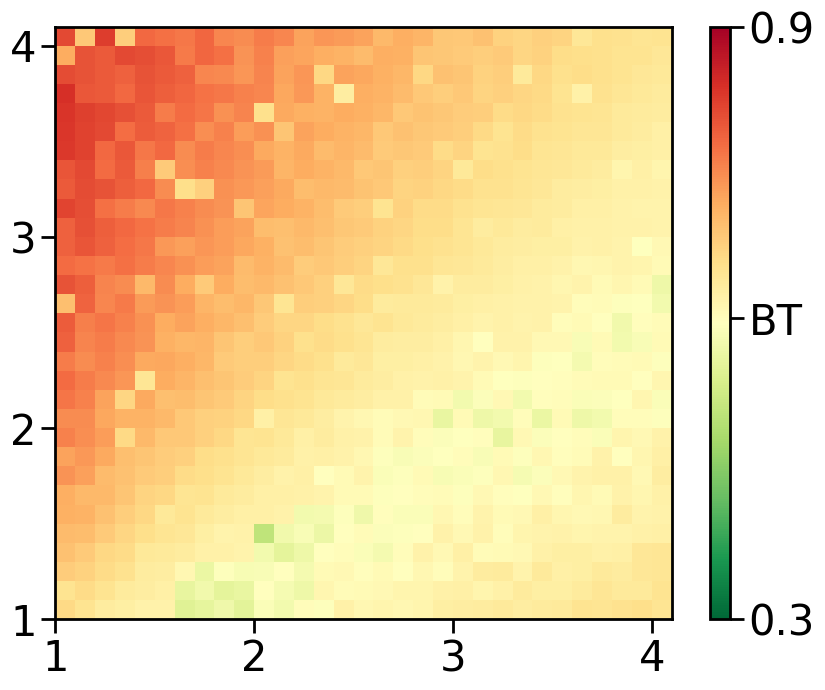

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes/Fixed Action/
data = torch.load('Susceptible/results_susceptibility 2/data-final.pt')




Bibmodal=np.zeros((len(data.keys()),len(data.keys())))
for eta1_idx in data.keys():
    for eta2_idx in data[0].keys():
      Bibmodal[eta1_idx,eta2_idx]=data[eta1_idx][eta2_idx]['bimodality']





v=[0.3,.55,0.9]
divnorm=colors.TwoSlopeNorm(vmin=v[0], vcenter=v[1], vmax=v[2])
fig, ax = plt.subplots(1,1,figsize=(8.5, 7))
cax=ax.pcolormesh(Bibmodal, cmap="RdYlGn_r", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax,ticks=[v[0] ,5/9,v[2]],aspect=30)
cbar.ax.set_yticklabels([str(v[0]), 'BT', str(v[2])])
cbar.ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
ax.set_xticks([0,10,20,30],[1,2,3,4])
ax.set_yticks([0,10,20,30],[1,2,3,4])




ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)
plt.tight_layout()
plt.savefig("plots/beta-Bimodal.svg",dpi=300)
plt.show()

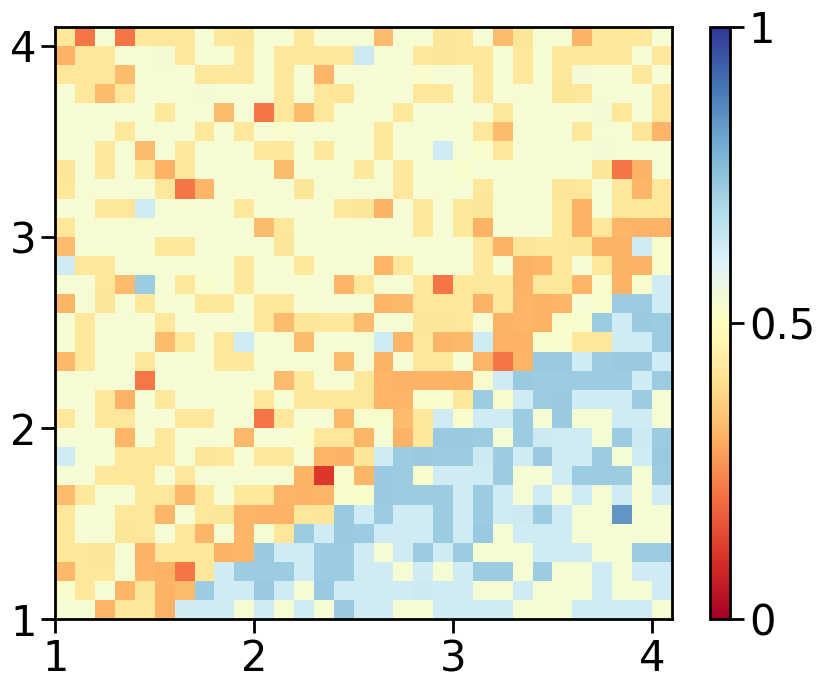

In [ ]:
credibility=np.zeros((len(data.keys()),len(data.keys())))
for eta1_idx in data.keys():
    for eta2_idx in data[0].keys():
      credibility[eta1_idx,eta2_idx]=data[eta1_idx][eta2_idx]['c'].mean()





v=[0,.5,1]
divnorm=colors.TwoSlopeNorm(vmin=v[0], vcenter=v[1], vmax=v[2])
fig, ax = plt.subplots(1,1,figsize=(8.5, 7))
cax=ax.pcolormesh(credibility, cmap="RdYlBu", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax,ticks=[v[0] ,v[1],v[2]],aspect=30)
cbar.ax.set_yticklabels([str(v[0]), '0.5', str(v[2])])
cbar.ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
ax.set_xticks([0,10,20,30],[1,2,3,4])
ax.set_yticks([0,10,20,30],[1,2,3,4])

# ax.set_yticks([0,5,10],[0,1,2])


ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)
plt.tight_layout()
plt.savefig("plots/beta-final-credibility.svg",dpi=300)
plt.show()

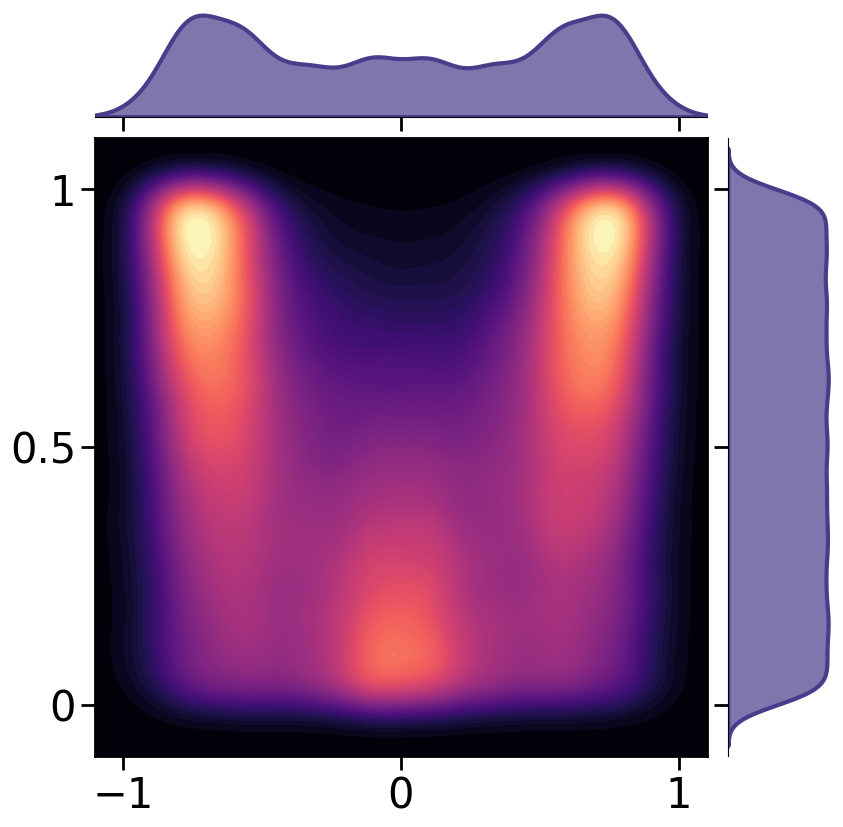

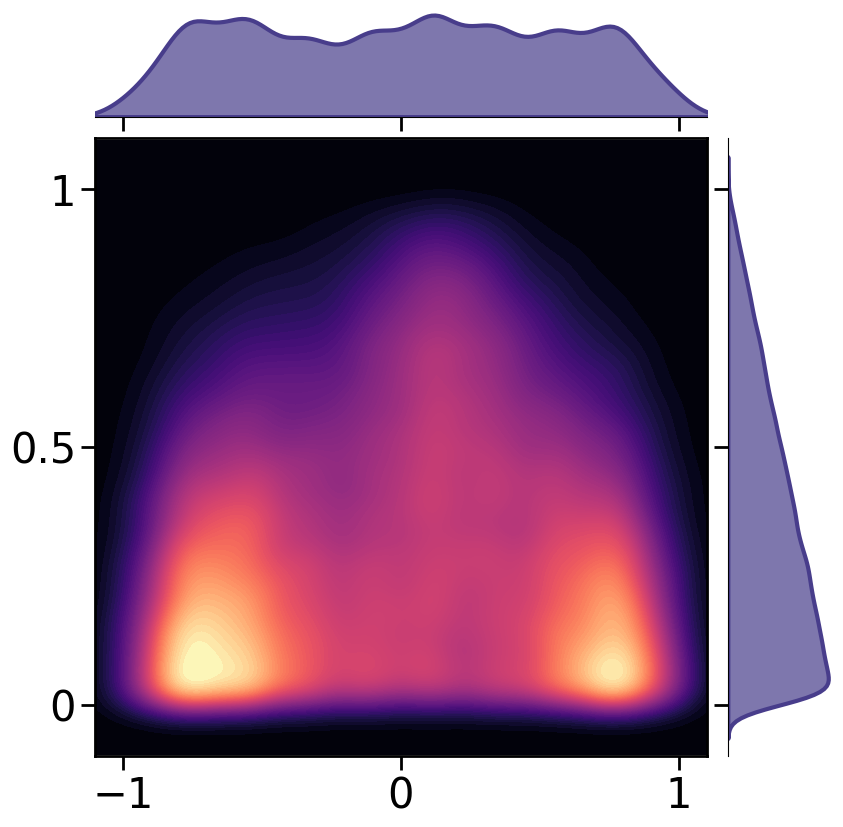

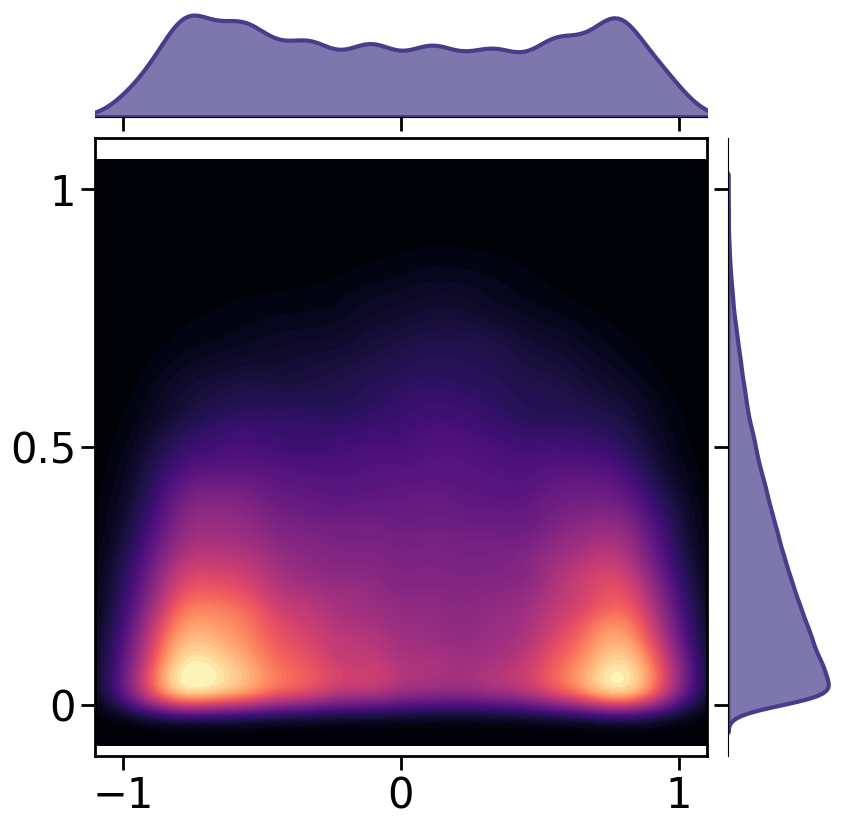

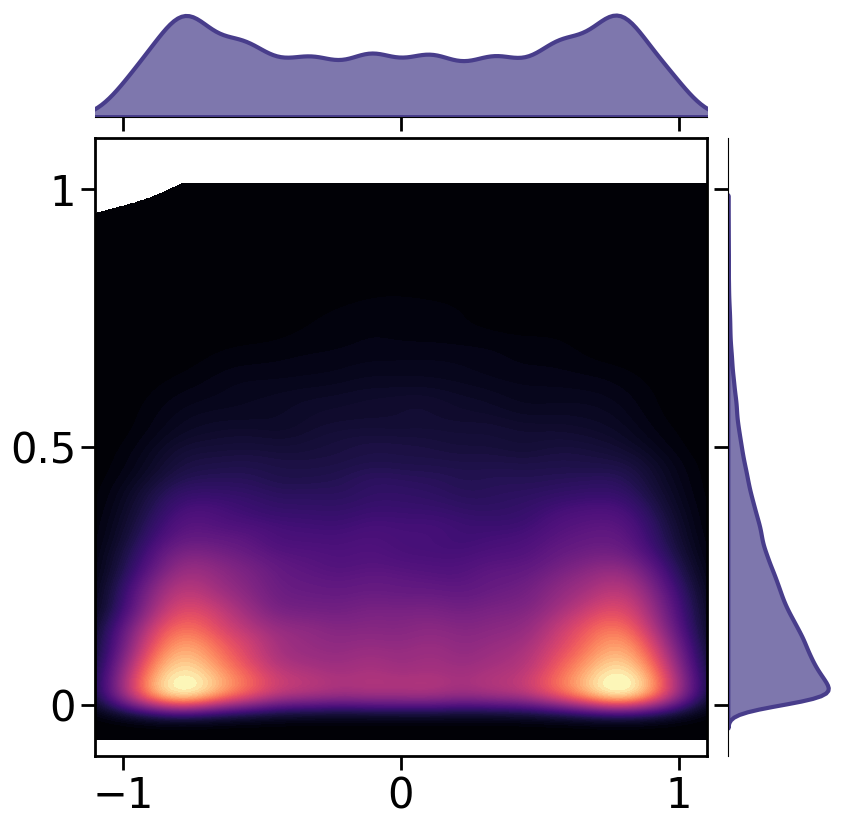

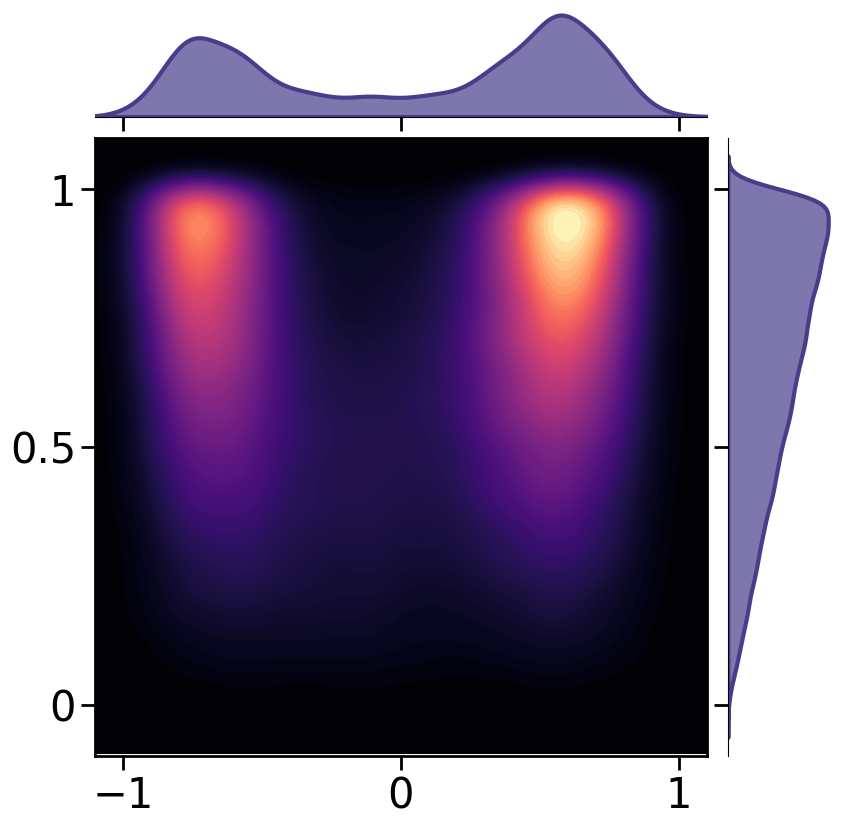

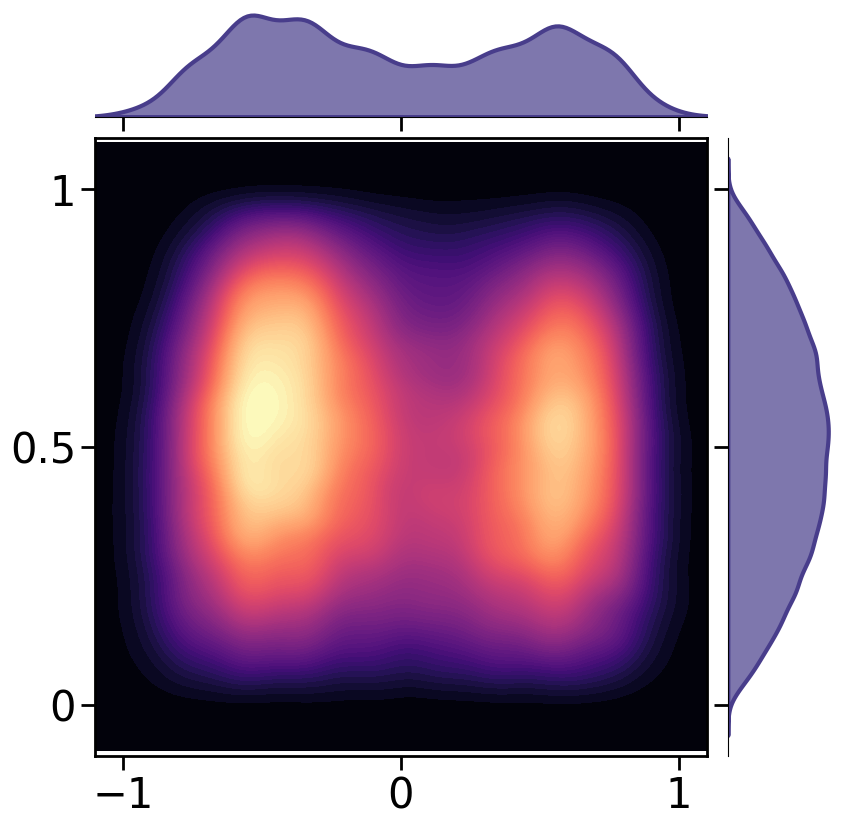

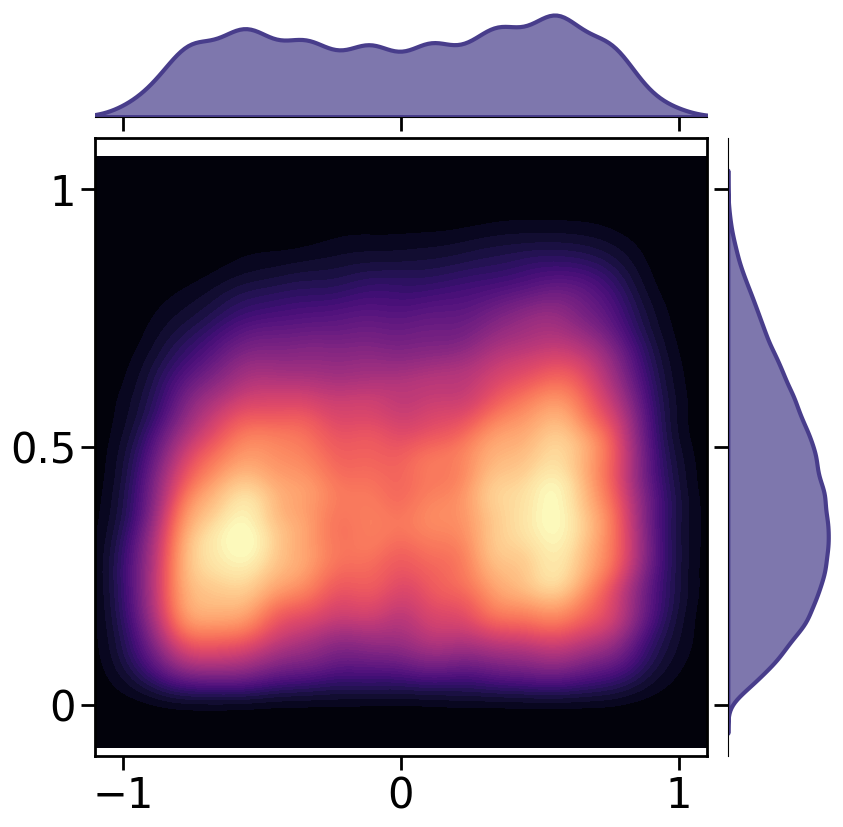

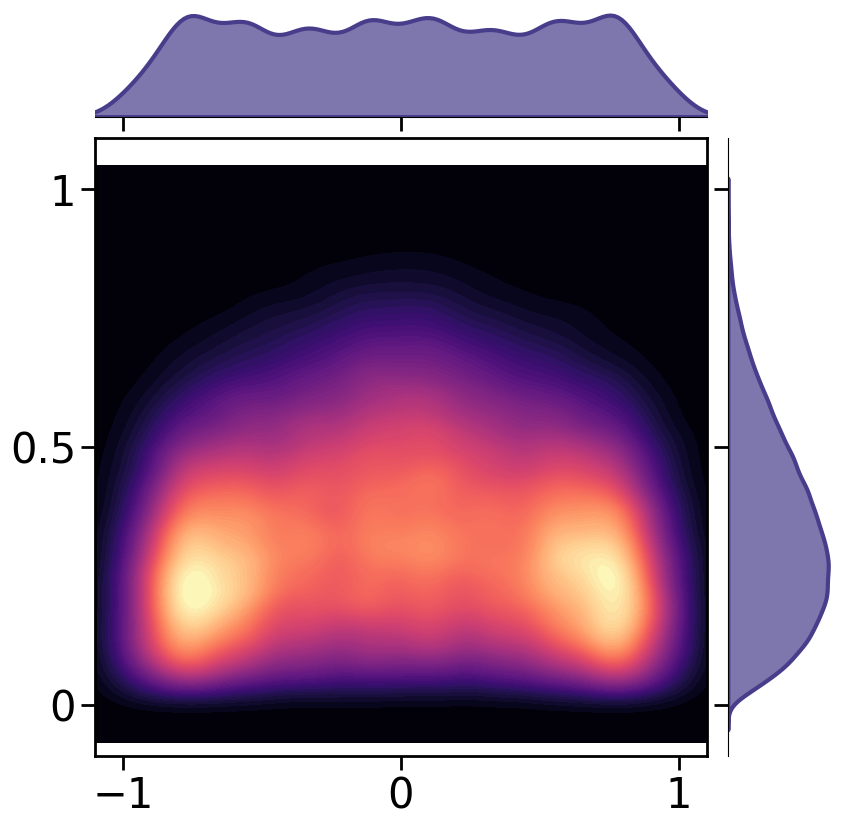

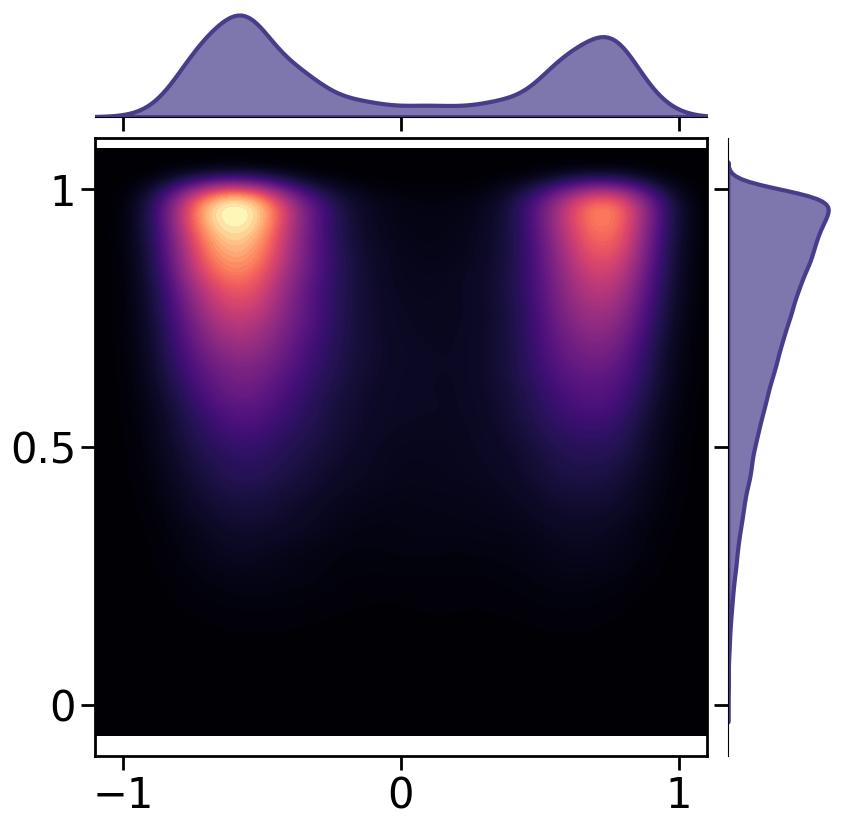

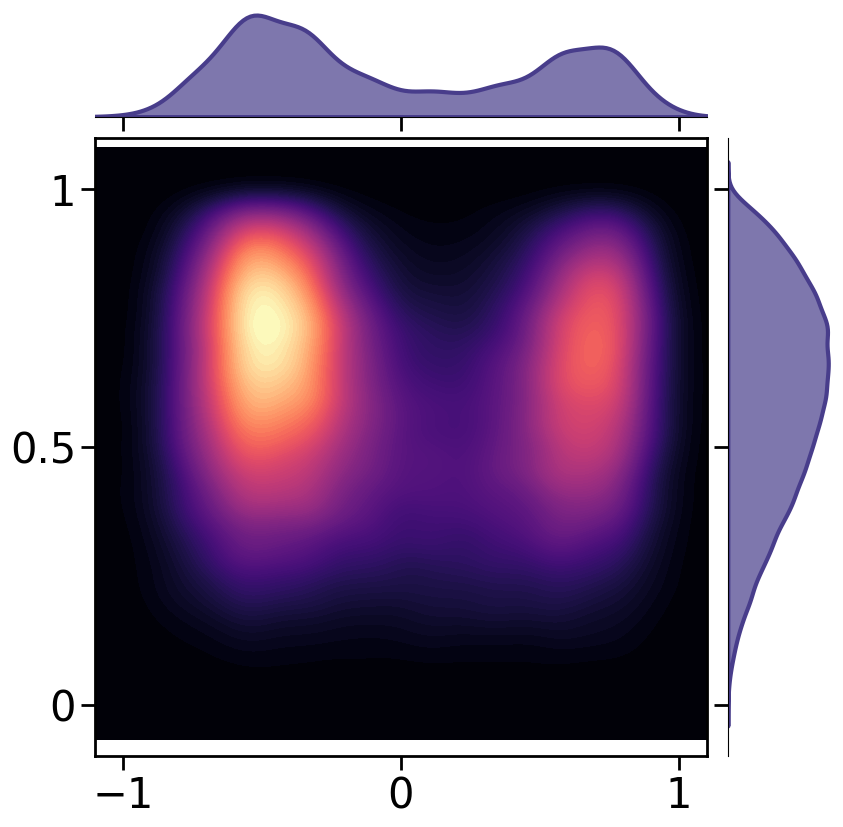

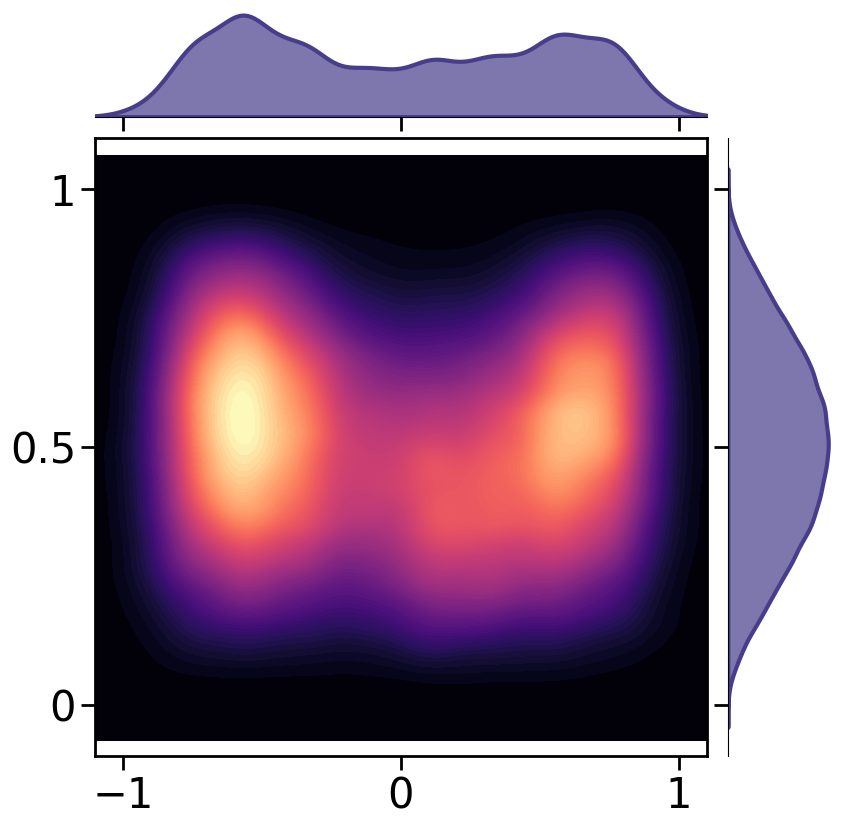

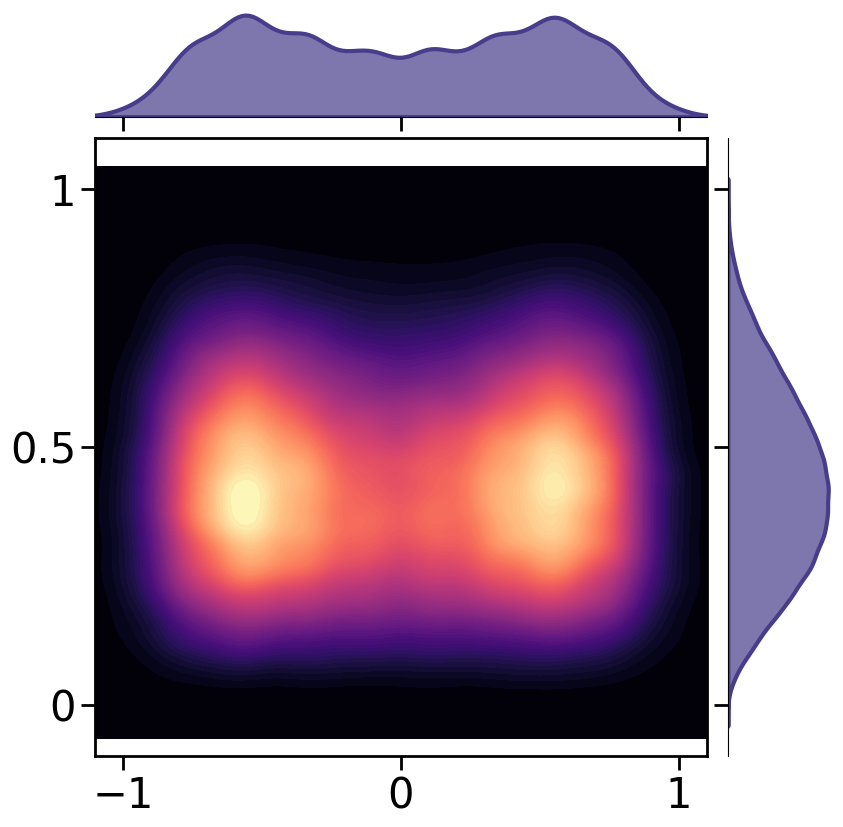

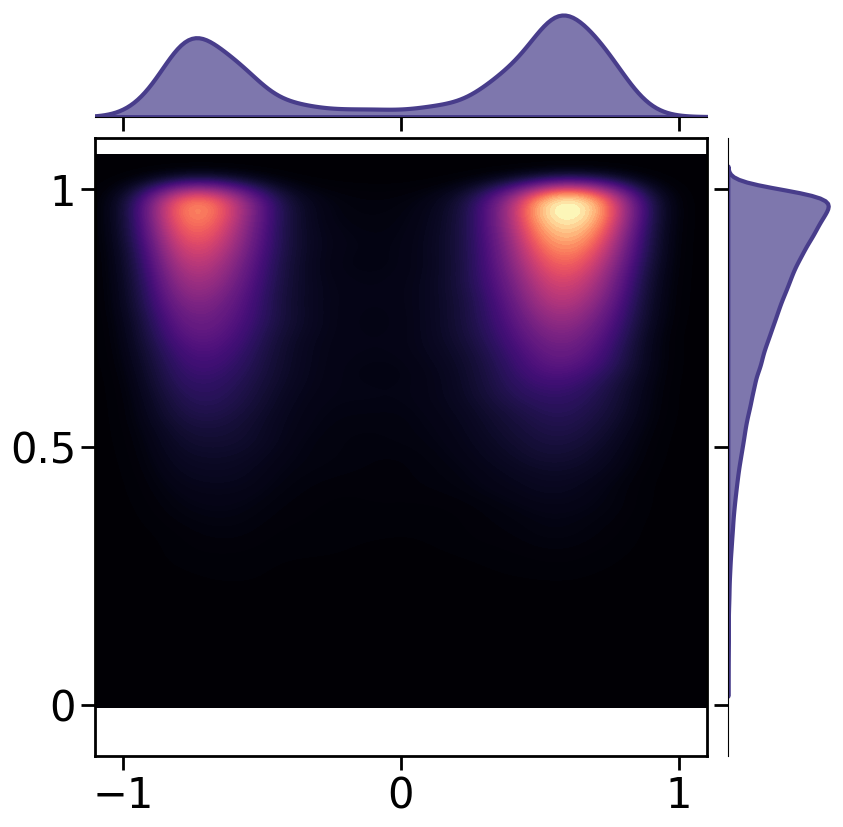

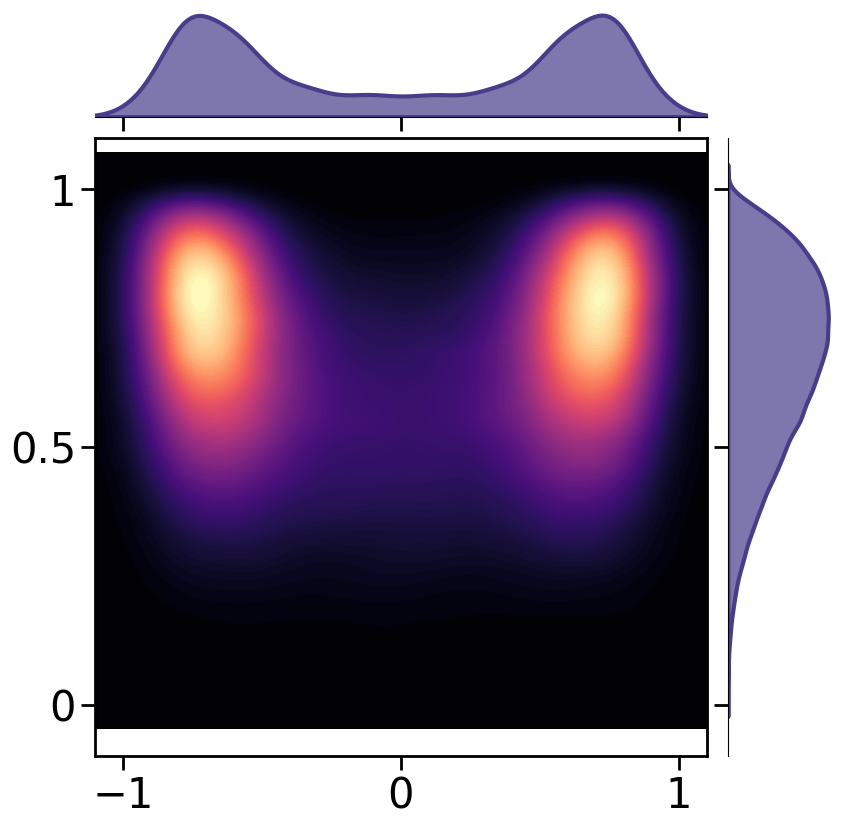

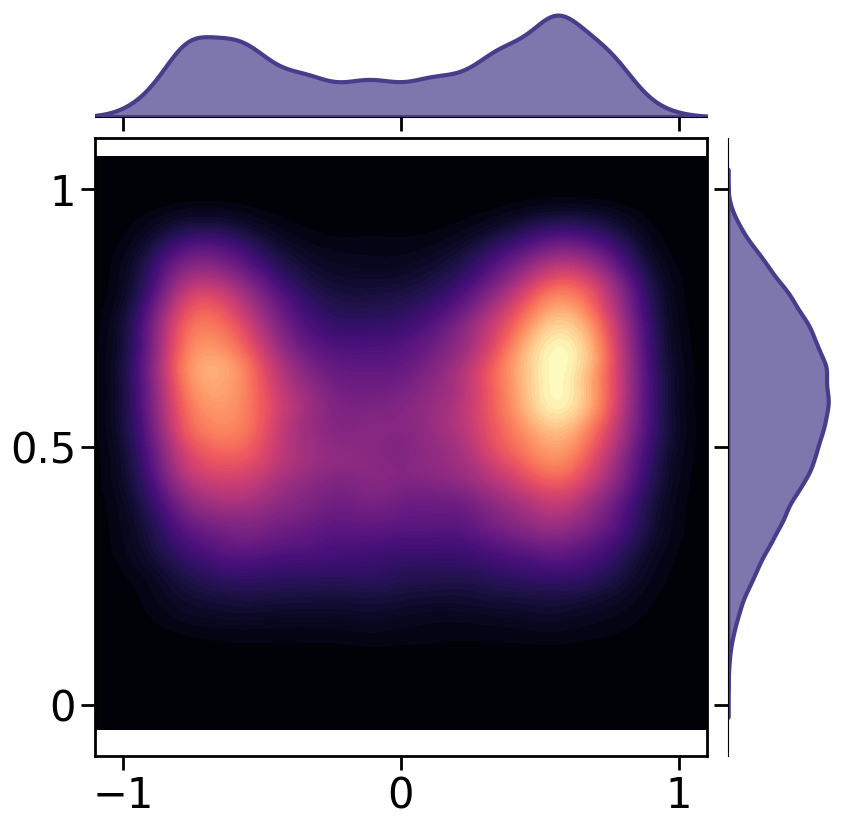

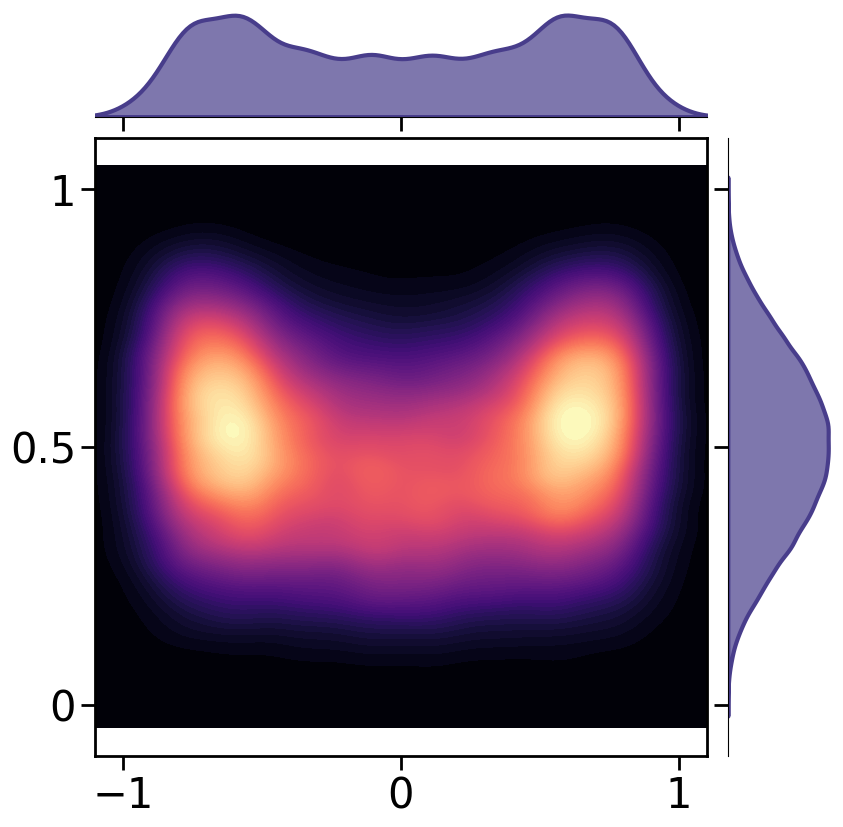

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
i,j=2,14
for i in [0, 10, 20, 30]:
    for j in [0, 10, 20, 30]:
        bet1=int(1+i/10)
        bet2=int(1+j/10)
        x=data[i][j]['x']
        s=data[i][j]['s']
        g = sns.JointGrid(height=8)
        sns.kdeplot(x=x, y=s, fill=True, ax=g.ax_joint,thresh=None,cmap="magma",levels=100)
        # sns.histplot(x=x, y=s, fill=True, ax=g.ax_joint,thresh=None,cmap="magma",bins=100)
        sns.kdeplot(x=x, color="darkslateblue", fill=True, ax=g.ax_marg_x,linewidth=3,alpha=0.7)
        sns.kdeplot(y=s, color="darkslateblue", fill=True, ax=g.ax_marg_y,linewidth=3,alpha=0.7)

        g.ax_joint.set_xlim([-1.1,1.1])
        g.ax_marg_y.set_ylim([-0.1,1.1])
        # g.ax_joint.set_ylim([0,1])
        g.ax_joint.spines['bottom'].set_linewidth(2)
        g.ax_joint.spines['left'].set_linewidth(2)
        g.ax_joint.spines['top'].set_linewidth(2)
        g.ax_joint.spines['right'].set_linewidth(2)
        g.ax_joint.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
        g.ax_joint.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
        g.ax_marg_y.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
        g.ax_marg_x.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)


        g.ax_joint.set_xticks([-1,0,1])
        g.ax_joint.set_yticks([0,0.5,1],[0,0.5,1])
        for _, spine in g.ax_joint.spines.items():
            spine.set_visible(True)
        plt.savefig('plots/beta'+str(bet1)+'_'+str(bet2)+'.svg',dpi=300)
        plt.show()


# Rationality

In [4]:
# calculate the nash equilibruim
!pip install nashpy
import nashpy as nash
import numpy as np

def nash_equilibrium(A):
    """
    Compute the Nash equilibrium strategies for a given payoff matrix A.
    """
    Ar=A/ np.abs(A).max()
    rps = nash.Game(Ar)
    eqs = rps.support_enumeration()
    policy=list(eqs)[0]
    return policy[0],policy[1]

def QRE(A, taw=0.1, device=device):
    """
    Compute a Quantal Response Equilibrium (QRE) solution for a given payoff matrix A.
    (This is essentially unchanged except for minor clarifications and explicit normalization.)
    """
    # Ar = A / A.abs().max()
    Ar=A
    mu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)
    nu = torch.softmax(torch.rand((Ar.shape[0], 1), device=device), dim=0)

    eta = 1 / 4000
    for _ in range( 3* 10**5):
        mu_old = mu.clone()
        nu_old = nu.clone()

        mub = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nu))
        mub = mub / mub.sum()
        nub = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mu))
        nub = nub / nub.sum()

        mu = mu.pow(1 - eta * taw) * torch.exp(eta * (Ar @ nub))
        mu = mu / mu.sum()
        nu = nu.pow(1 - eta * taw) * torch.exp(-eta * (Ar.t() @ mub))
        nu = nu / nu.sum()

        # Compute the duality gap; stop if it is sufficiently small.
        DG = (nu_old.t() @ Ar @ mu) - (nu.t() @ Ar @ mu_old)
        if DG.abs().item() < 1e-10:
            print("converged!")
            return mu, nu
    print(f"not converged, duality gap: {DG.abs().item()}")
    return mu, nu


def Generator_rationality(env, Taw=0.1,nash=False):
    """
    Load the payoff matrix A, compute a QRE (which gives a probability distribution over actions),
    instantiate the updated environment OpinionEnv9Actions, sample one action (per “player”) from the QRE,
    run a simulation, and return the final opinions x, susceptibilities s, and credibility c.
    (The fourth returned value is set to None because the previous code returned env.AEm which is no longer defined.)
    """
    # Load the payoff matrix from file.
    load_file=f'Payoff_matrix/Payoff-eta1_1.0eta2_1.0.pt'
    A = torch.load(load_file)
    M = 10
    N = 500
    terminal_time = 200

    # Compute the QRE equilibrium strategies.
    if nash:
        mu, nu = nash_equilibrium(A.cpu().numpy())
        mu = torch.tensor(mu,device=device)
        nu = torch.tensor(nu,device=device)
    else:
        mu, nu = QRE(A, taw=Taw, device=device)
        if torch.any(mu < 0) or torch.isnan(mu).any() or mu.sum() <= 0:
          print("Invalid probability distribution in mu:", mu)
          raise ValueError("mu contains invalid values for multinomial sampling")

    # Sample one action index for each of the two “players” from the QRE distributions.
    # We use num_samples=1 so that a single action is applied to all parallel environments.
    action_i = torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.num_envs, replacement=True)
    action_j = torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.num_envs, replacement=True)
    # Run the simulation using the selected actions.
    rewards=run_simulation(action_i, action_j, env)
    # Extract the final state components.
    # In the new environment, opinions are stored in env.x, credibility in env.c, and susceptibility in env.s.
    x = env.x.cpu().numpy().flatten()
    s = env.s.cpu().numpy().flatten()
    c = env.c.cpu().numpy().flatten()
    AEm=env.AEm.cpu().numpy().flatten()

    # The original code returned a fourth variable (env.AEm); here we return None.
    return x, s, c, AEm,rewards


# Parameters
M = 10
N = 500

taw_list = np.arange(-2, 2, 0.1)
env = OpinionEnv9Actions(
    num_envs=1000,
    N=N,
    M=M,
    terminal_time=200,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)


os.makedirs('results_rationality', exist_ok=True)
# Define the ranges for eta values.
data = {}       # Dictionary to store full simulation output
# Loop over the grid of eta values with nested progress bars.
for i, taw in tqdm(enumerate(taw_list), total=len(taw_list), desc="Rationality Loop"):

        # Run the simulation for the current eta1 and eta2 combination.
        env.reset()
        x, s, c, AEm ,rewards= Generator_rationality(env,Taw=10**taw)
        # Store the results in the dictionary.
        data[i] = {'x': x,
                      's': s,
                      'c': c,
                      'AEm': AEm,
                      'bimodality':bimodality_coefficient(x),
                      'avg_c':c.mean(),
                      'avg_AE':AEm.mean() if AEm is not None else np.nan,
                      'rewards':rewards
                      }
        print(f"{10**taw:0.2f},{bimodality_coefficient(x):0.2f}")



env.reset()
x, s, c, AEm ,rewards= Generator_rationality(env,Taw=10**taw,nash=True)
# Store the results in the dictionary.
data['nash'] = {'x': x,
              's': s,
              'c': c,
              'AEm': AEm,
              'bimodality':bimodality_coefficient(x),
              'avg_c':c.mean(),
              'avg_AE':AEm.mean() if AEm is not None else np.nan,
              'rewards':rewards
              }


print(f"Nash, {bimodality_coefficient(x):0.2f}")
torch.save(data, 'results_rationality/data-final.pt')



Rationality Loop:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-4-5a1915aaf35d>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  A = torch.load(load_file)


converged!


Rationality Loop:   2%|▎         | 1/40 [00:25<16:15, 25.00s/it]

0.01,0.66
converged!


Rationality Loop:   5%|▌         | 2/40 [00:46<14:26, 22.79s/it]

0.01,0.66
converged!


Rationality Loop:   8%|▊         | 3/40 [01:06<13:12, 21.42s/it]

0.02,0.67
converged!


Rationality Loop:  10%|█         | 4/40 [01:28<13:10, 21.96s/it]

0.02,0.66
converged!


Rationality Loop:  12%|█▎        | 5/40 [01:49<12:33, 21.54s/it]

0.03,0.67
converged!


Rationality Loop:  15%|█▌        | 6/40 [02:10<12:00, 21.19s/it]

0.03,0.67
converged!


Rationality Loop:  18%|█▊        | 7/40 [02:30<11:30, 20.92s/it]

0.04,0.67
converged!


Rationality Loop:  20%|██        | 8/40 [02:49<10:51, 20.37s/it]

0.05,0.67
converged!


Rationality Loop:  22%|██▎       | 9/40 [03:11<10:42, 20.73s/it]

0.06,0.66
converged!


Rationality Loop:  25%|██▌       | 10/40 [03:33<10:32, 21.08s/it]

0.08,0.66
converged!


Rationality Loop:  28%|██▊       | 11/40 [03:56<10:30, 21.75s/it]

0.10,0.66
converged!


Rationality Loop:  30%|███       | 12/40 [04:17<10:02, 21.51s/it]

0.13,0.66
converged!


Rationality Loop:  32%|███▎      | 13/40 [04:38<09:36, 21.37s/it]

0.16,0.66
converged!


Rationality Loop:  35%|███▌      | 14/40 [04:58<09:07, 21.06s/it]

0.20,0.66
converged!


Rationality Loop:  38%|███▊      | 15/40 [05:18<08:35, 20.61s/it]

0.25,0.66
converged!


Rationality Loop:  40%|████      | 16/40 [05:42<08:43, 21.81s/it]

0.32,0.65
converged!


Rationality Loop:  42%|████▎     | 17/40 [06:05<08:24, 21.93s/it]

0.40,0.65
converged!


Rationality Loop:  45%|████▌     | 18/40 [06:23<07:39, 20.87s/it]

0.50,0.65
converged!


Rationality Loop:  48%|████▊     | 19/40 [06:39<06:45, 19.33s/it]

0.63,0.65
converged!


Rationality Loop:  50%|█████     | 20/40 [06:56<06:13, 18.65s/it]

0.79,0.64
converged!


Rationality Loop:  52%|█████▎    | 21/40 [07:15<05:55, 18.70s/it]

1.00,0.64
converged!


Rationality Loop:  55%|█████▌    | 22/40 [07:30<05:16, 17.58s/it]

1.26,0.63
converged!


Rationality Loop:  57%|█████▊    | 23/40 [07:53<05:27, 19.28s/it]

1.58,0.62
converged!


Rationality Loop:  60%|██████    | 24/40 [08:06<04:41, 17.57s/it]

2.00,0.61
converged!


Rationality Loop:  62%|██████▎   | 25/40 [08:20<04:06, 16.41s/it]

2.51,0.60
converged!


Rationality Loop:  65%|██████▌   | 26/40 [08:33<03:35, 15.37s/it]

3.16,0.59
converged!


Rationality Loop:  68%|██████▊   | 27/40 [08:46<03:08, 14.53s/it]

3.98,0.58
converged!


Rationality Loop:  70%|███████   | 28/40 [08:58<02:44, 13.74s/it]

5.01,0.57
converged!


Rationality Loop:  72%|███████▎  | 29/40 [09:12<02:32, 13.83s/it]

6.31,0.57
converged!


Rationality Loop:  75%|███████▌  | 30/40 [09:24<02:13, 13.32s/it]

7.94,0.56
converged!


Rationality Loop:  78%|███████▊  | 31/40 [09:35<01:55, 12.83s/it]

10.00,0.56
converged!


Rationality Loop:  80%|████████  | 32/40 [09:47<01:39, 12.49s/it]

12.59,0.56
converged!


Rationality Loop:  82%|████████▎ | 33/40 [09:58<01:24, 12.05s/it]

15.85,0.55
converged!


Rationality Loop:  85%|████████▌ | 34/40 [10:10<01:11, 11.96s/it]

19.95,0.55
converged!


Rationality Loop:  88%|████████▊ | 35/40 [10:21<00:59, 11.80s/it]

25.12,0.55
converged!


Rationality Loop:  90%|█████████ | 36/40 [10:33<00:46, 11.73s/it]

31.62,0.55
converged!


Rationality Loop:  92%|█████████▎| 37/40 [10:44<00:34, 11.61s/it]

39.81,0.55
converged!


Rationality Loop:  95%|█████████▌| 38/40 [10:55<00:22, 11.47s/it]

50.12,0.55
converged!


Rationality Loop:  98%|█████████▊| 39/40 [11:07<00:11, 11.39s/it]

63.10,0.55
converged!


Rationality Loop: 100%|██████████| 40/40 [11:18<00:00, 16.95s/it]

79.43,0.55


Nash, 0.64


<ipython-input-13-85e9d35e80d6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load('results_rationality/data-final.pt')


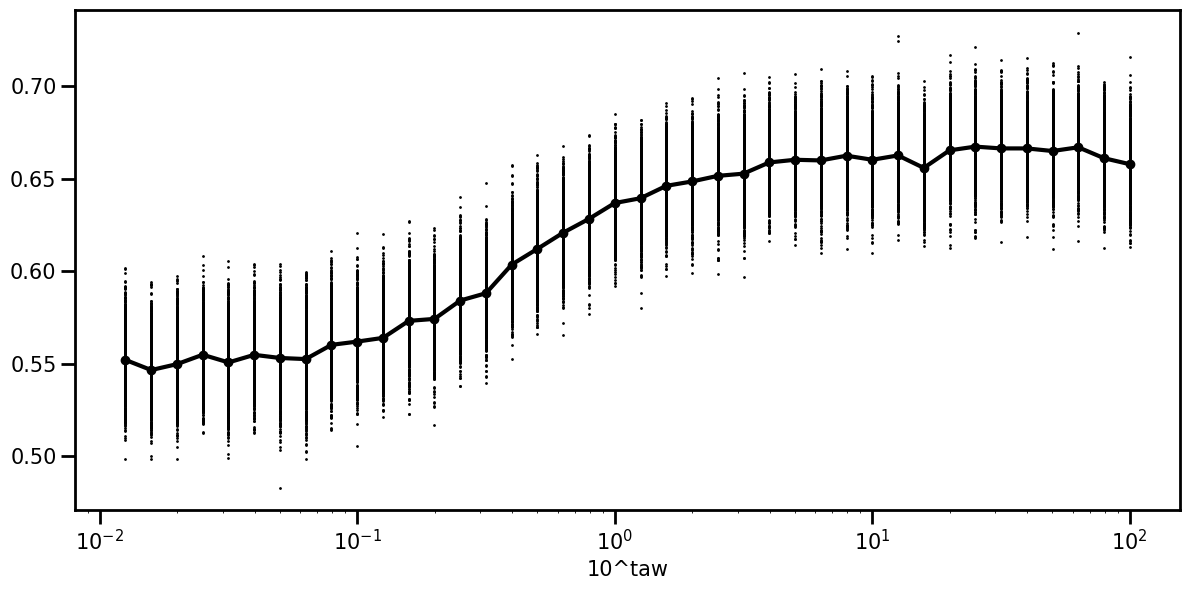

In [13]:
import matplotlib.pyplot as plt
import numpy as np
data=torch.load('results_rationality/data-final.pt')
# Assuming taw_list and data are already defined
taw_list = np.arange(-2, 2, 0.1)
fig, ax = plt.subplots(figsize=(12, 6))

# Extract x and y values
x_vals = [10**(-taw) for taw in taw_list]
y_vals = [data[key]['bimodality'] for key in range(len(taw_list))]


for key in range(len(taw_list)):
    ax.scatter(10**(-taw_list[key])*np.ones((1000,)),bimodality_coefficient(data[key]['x'].reshape(500,-1)),s=1,c='k')


# Plot the line with a solid style and a thick width
ax.plot(x_vals, y_vals, linestyle='-', linewidth=3, color='black',marker="o")

# Use logarithmic scaling on the x-axis
ax.set_xscale('log')

# Set labels with a larger font size
ax.set_xlabel('10^taw', fontsize=15)
# ax.set_ylabel('Bimodality', fontsize=15)

# Customize tick parameters
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)

# Thicken all the spines for a bold look
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
# Optionally, save the figure
plt.savefig('results_rationality/rational-exposire-simple.svg')
plt.show()


In [12]:
bimodality_coefficient(data[key]['x'].reshape(500,-1))

(1000,)

<ipython-input-14-6c8978e31167>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('results_rationality/data-final.pt')


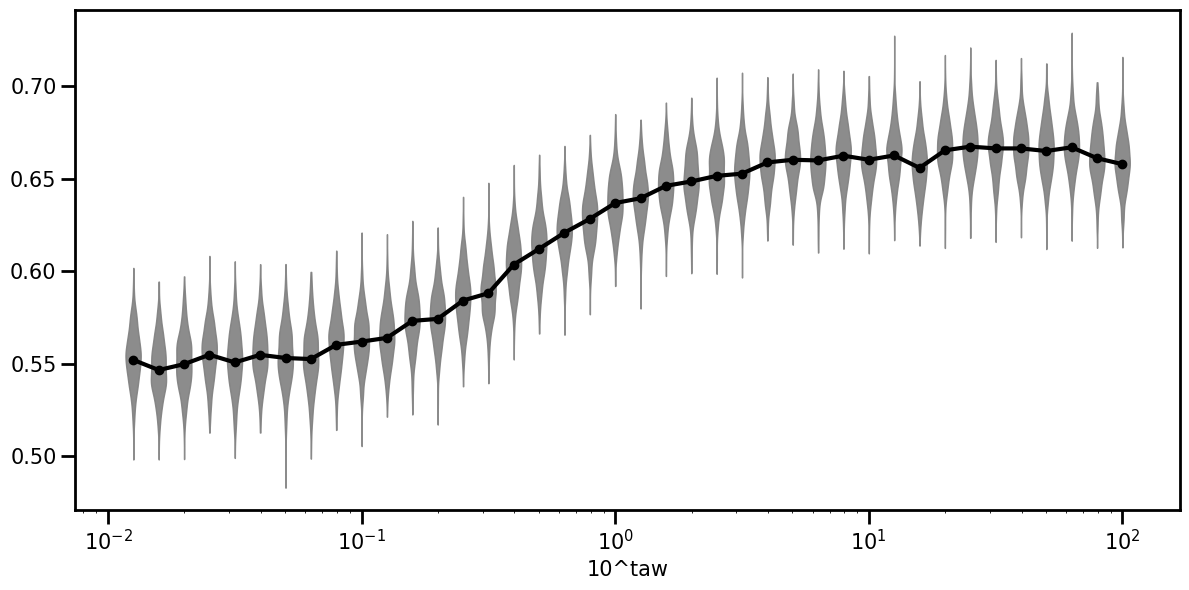

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

data = torch.load('results_rationality/data-final.pt')
taw_list = np.arange(-2, 2, 0.1)
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare x and y values for the line plot
x_vals = [10**(-taw) for taw in taw_list]
y_vals = [data[key]['bimodality'] for key in range(len(taw_list))]

# Set a constant width in log10 units (adjust as needed)
w_log = 0.06

# Plot violin plots for each distribution (solid gray)
for key, taw in enumerate(taw_list):
    x_pos = 10**(-taw)
    # Compute width in data coordinates corresponding to w_log constant in log10 space
    width = 10**(np.log10(x_pos) + w_log/2) - 10**(np.log10(x_pos) - w_log/2)

    # Convert distribution data to numpy and flatten it.
    dist = bimodality_coefficient(data[key]['x'].reshape(500,-1))

    # Create a violin plot at the given x position with the computed width
    vp = ax.violinplot(dist, positions=[x_pos], widths=width, showextrema=False)

    # Set the color of the violin bodies to a solid gray
    for body in vp['bodies']:
        body.set_facecolor('gray')
        body.set_edgecolor('gray')
        body.set_alpha(.9)  # Ensure full opacity

# Plot the line with a solid style, thick width, and circle markers
ax.plot(x_vals, y_vals, linestyle='-', linewidth=3, color='black', marker="o")

# Use logarithmic scaling on the x-axis
ax.set_xscale('log')

# Set the x-axis label with a larger font size
ax.set_xlabel('taw', fontsize=15)

# Customize tick parameters for a bold look
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)

# Thicken all the spines for a bold look
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig('results_rationality/rational-exposure.svg')
plt.show()


39
30
20
10
0
nash


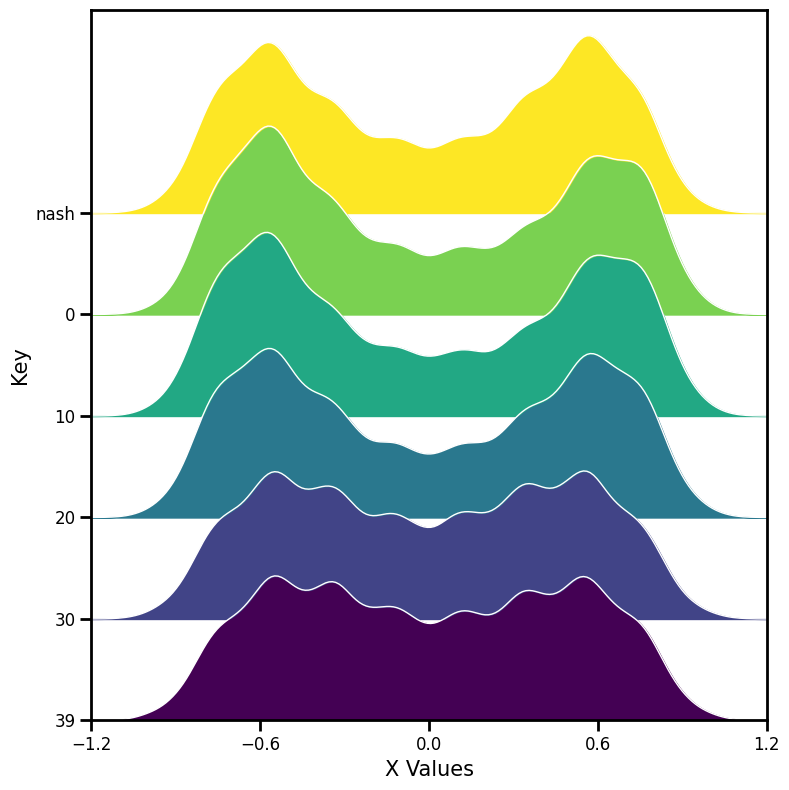

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming `data` dictionary is already defined

fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 6)]  # Generate colors for each key

vertical_shift = 1  # Space between distributions
scale_factor = 2  # Scaling for better visualization
yp = 0.0

keys = [39,30,20,10,0, 'nash']  # The keys to plot
for idx, key in enumerate(keys):
    print(key)
    x_data = np.array(data[key]['x'])  # Extract x values
    kde = stats.gaussian_kde(x_data)  # Compute KDE
    x_vals = np.linspace(-1.2, 1.2, 200)  # Range for KDE
    y_vals = kde(x_vals) * scale_factor + idx * vertical_shift  # Scale and shift

    # Fill and outline the KDE plot
    ax.fill_between(
        x_vals,
        np.maximum(idx * vertical_shift, yp),
        y_vals,
        color=colors[idx],
        alpha=1
    )
    ax.plot(x_vals, y_vals, color='white', linewidth=1)  # White outline

    yp = y_vals  # Track previous y-values for proper stacking

# Set limits
ax.set_xlim([min(x_vals), max(x_vals)])
ax.set_ylim([0, idx * vertical_shift + scale_factor])

# Customize ticks and labels
ax.set_xticks(np.linspace(min(x_vals), max(x_vals), 5))
ax.set_yticks([i * vertical_shift for i in range(len(keys))])
ax.set_yticklabels([str(key) for key in keys])  # Label y-axis with the keys

ax.tick_params(axis='x', which='major', labelsize=12, width=2, length=8)
ax.tick_params(axis='y', which='major', labelsize=12, width=2, length=8)

# Thicken the spines for a polished look
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel("X Values", fontsize=15)
plt.ylabel("Key", fontsize=15)
plt.tight_layout()
# plt.savefig("results_rationality/distribution-exposure.svg")
plt.show()
